# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.66KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

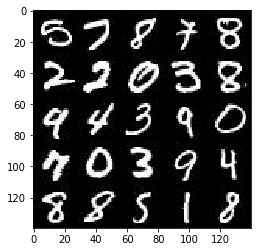

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

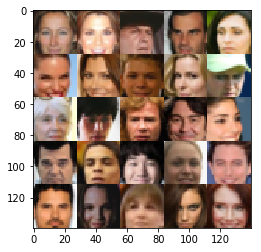

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_inputs = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels),
                                  name='real_inputs')
    z_input = tf.placeholder(tf.float32,
                              (None, z_dim),
                              name='z_input')
    
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return real_inputs, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    std_dev = 0.02
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # first layer will spit out 28 dim
        conv_1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        relu_1 = tf.maximum(alpha*conv_1, conv_1)
        
        # second layer will spit out 14 dim
        conv_2 = tf.layers.conv2d(relu_1, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        bn_1 = tf.layers.batch_normalization(conv_2, training=True)
        relu_2 = tf.maximum(alpha*bn_1, bn_1)
        
        #third layer will spit out 7 dim
        conv_3 = tf.layers.conv2d(relu_2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        bn_2 = tf.layers.batch_normalization(conv_3, training=True)
        relu_3 = tf.maximum(alpha*bn_2, bn_2)
         
        #final layer: back to where it begin
        flat = tf.reshape(relu_3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        
        alpha = 0.2
        std_dev = 0.02
        
        # first layer will spit out 7 dim
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
         # second layer will spit out 14 dim
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
       
        # third layer will spit out 28 dim
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev) )
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        # final layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=std_dev))
        
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    disc_model_real, disc_logits_real = discriminator(input_real, reuse=False)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= disc_logits_fake, labels=tf.ones_like(disc_model_fake)))
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= disc_logits_real, labels=tf.ones_like(disc_model_real) * (1 - smooth)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    disc_loss = disc_loss_real + disc_loss_fake                            
                            
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    size = data_shape[1]
    dim = 3 if data_image_mode=="RGB" else 1
       
    input_real, input_z, var_learning_rate = model_inputs(size, size, dim, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, var_learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 20
    show_every = 200
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                                
                images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    input_real: images,
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                   })
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                })
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.3f}...".format(train_loss_d),
                          "Generator Loss: {:.3f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.458... Generator Loss: 0.682
Epoch 1/2... Discriminator Loss: 1.003... Generator Loss: 1.501
Epoch 1/2... Discriminator Loss: 1.091... Generator Loss: 1.388
Epoch 1/2... Discriminator Loss: 1.320... Generator Loss: 0.685
Epoch 1/2... Discriminator Loss: 1.292... Generator Loss: 0.990
Epoch 1/2... Discriminator Loss: 1.251... Generator Loss: 0.687
Epoch 1/2... Discriminator Loss: 1.190... Generator Loss: 1.053
Epoch 1/2... Discriminator Loss: 1.164... Generator Loss: 1.301
Epoch 1/2... Discriminator Loss: 1.231... Generator Loss: 1.467
Epoch 1/2... Discriminator Loss: 1.069... Generator Loss: 1.131


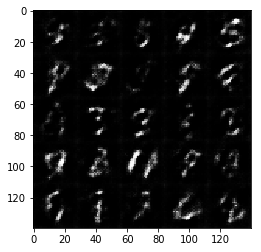

Epoch 1/2... Discriminator Loss: 1.058... Generator Loss: 1.040
Epoch 1/2... Discriminator Loss: 0.985... Generator Loss: 1.141
Epoch 1/2... Discriminator Loss: 1.094... Generator Loss: 0.847
Epoch 1/2... Discriminator Loss: 1.073... Generator Loss: 0.837
Epoch 1/2... Discriminator Loss: 0.863... Generator Loss: 1.213
Epoch 1/2... Discriminator Loss: 1.072... Generator Loss: 0.898
Epoch 1/2... Discriminator Loss: 0.921... Generator Loss: 1.233
Epoch 1/2... Discriminator Loss: 1.024... Generator Loss: 1.132
Epoch 1/2... Discriminator Loss: 1.148... Generator Loss: 0.710
Epoch 1/2... Discriminator Loss: 0.910... Generator Loss: 1.147


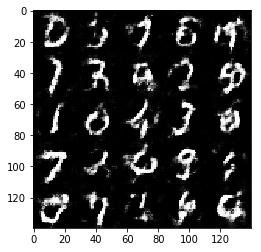

Epoch 1/2... Discriminator Loss: 1.026... Generator Loss: 0.922
Epoch 1/2... Discriminator Loss: 1.028... Generator Loss: 1.612
Epoch 1/2... Discriminator Loss: 1.000... Generator Loss: 1.133
Epoch 1/2... Discriminator Loss: 1.248... Generator Loss: 0.747
Epoch 1/2... Discriminator Loss: 1.024... Generator Loss: 0.941
Epoch 1/2... Discriminator Loss: 1.066... Generator Loss: 0.886
Epoch 1/2... Discriminator Loss: 1.096... Generator Loss: 0.968
Epoch 1/2... Discriminator Loss: 1.062... Generator Loss: 1.020
Epoch 1/2... Discriminator Loss: 0.972... Generator Loss: 1.301
Epoch 1/2... Discriminator Loss: 1.162... Generator Loss: 1.590


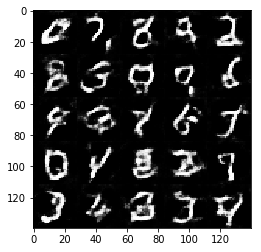

Epoch 1/2... Discriminator Loss: 1.112... Generator Loss: 0.792
Epoch 1/2... Discriminator Loss: 1.044... Generator Loss: 1.026
Epoch 1/2... Discriminator Loss: 1.284... Generator Loss: 0.578
Epoch 1/2... Discriminator Loss: 0.969... Generator Loss: 1.198
Epoch 1/2... Discriminator Loss: 1.074... Generator Loss: 1.201
Epoch 1/2... Discriminator Loss: 1.111... Generator Loss: 1.030
Epoch 1/2... Discriminator Loss: 1.318... Generator Loss: 0.601
Epoch 1/2... Discriminator Loss: 1.157... Generator Loss: 1.596
Epoch 1/2... Discriminator Loss: 1.026... Generator Loss: 1.292
Epoch 1/2... Discriminator Loss: 1.090... Generator Loss: 0.836


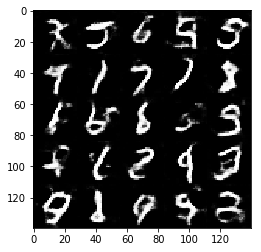

Epoch 1/2... Discriminator Loss: 1.206... Generator Loss: 1.576
Epoch 1/2... Discriminator Loss: 1.083... Generator Loss: 0.785
Epoch 1/2... Discriminator Loss: 1.106... Generator Loss: 1.255
Epoch 1/2... Discriminator Loss: 1.110... Generator Loss: 0.910
Epoch 1/2... Discriminator Loss: 1.054... Generator Loss: 1.014
Epoch 1/2... Discriminator Loss: 1.061... Generator Loss: 0.985
Epoch 2/2... Discriminator Loss: 1.084... Generator Loss: 1.474
Epoch 2/2... Discriminator Loss: 0.972... Generator Loss: 1.338
Epoch 2/2... Discriminator Loss: 1.011... Generator Loss: 1.279
Epoch 2/2... Discriminator Loss: 0.951... Generator Loss: 1.025


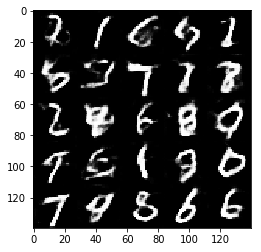

Epoch 2/2... Discriminator Loss: 0.960... Generator Loss: 1.056
Epoch 2/2... Discriminator Loss: 0.983... Generator Loss: 1.062
Epoch 2/2... Discriminator Loss: 1.017... Generator Loss: 1.013
Epoch 2/2... Discriminator Loss: 1.098... Generator Loss: 0.813
Epoch 2/2... Discriminator Loss: 1.291... Generator Loss: 0.557
Epoch 2/2... Discriminator Loss: 1.177... Generator Loss: 0.662
Epoch 2/2... Discriminator Loss: 1.048... Generator Loss: 1.125
Epoch 2/2... Discriminator Loss: 0.930... Generator Loss: 1.666
Epoch 2/2... Discriminator Loss: 1.025... Generator Loss: 0.941
Epoch 2/2... Discriminator Loss: 1.055... Generator Loss: 0.837


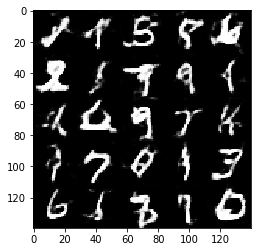

Epoch 2/2... Discriminator Loss: 0.874... Generator Loss: 1.388
Epoch 2/2... Discriminator Loss: 0.838... Generator Loss: 1.322
Epoch 2/2... Discriminator Loss: 1.340... Generator Loss: 0.539
Epoch 2/2... Discriminator Loss: 0.983... Generator Loss: 1.334
Epoch 2/2... Discriminator Loss: 0.971... Generator Loss: 0.957
Epoch 2/2... Discriminator Loss: 0.927... Generator Loss: 1.055
Epoch 2/2... Discriminator Loss: 1.051... Generator Loss: 0.922
Epoch 2/2... Discriminator Loss: 0.925... Generator Loss: 1.452
Epoch 2/2... Discriminator Loss: 0.949... Generator Loss: 0.976
Epoch 2/2... Discriminator Loss: 1.152... Generator Loss: 0.691


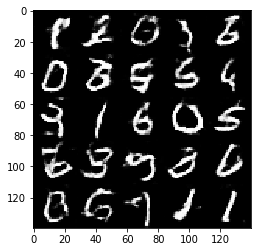

Epoch 2/2... Discriminator Loss: 1.453... Generator Loss: 0.460
Epoch 2/2... Discriminator Loss: 1.000... Generator Loss: 1.006
Epoch 2/2... Discriminator Loss: 0.930... Generator Loss: 1.023
Epoch 2/2... Discriminator Loss: 1.093... Generator Loss: 0.728
Epoch 2/2... Discriminator Loss: 0.912... Generator Loss: 1.502
Epoch 2/2... Discriminator Loss: 0.949... Generator Loss: 1.224
Epoch 2/2... Discriminator Loss: 0.947... Generator Loss: 1.079
Epoch 2/2... Discriminator Loss: 0.962... Generator Loss: 1.141
Epoch 2/2... Discriminator Loss: 1.075... Generator Loss: 0.818
Epoch 2/2... Discriminator Loss: 1.923... Generator Loss: 0.296


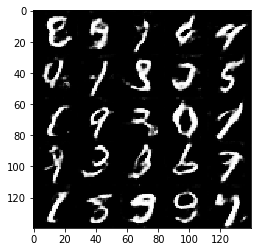

Epoch 2/2... Discriminator Loss: 0.999... Generator Loss: 0.992
Epoch 2/2... Discriminator Loss: 0.951... Generator Loss: 1.292
Epoch 2/2... Discriminator Loss: 1.326... Generator Loss: 0.515
Epoch 2/2... Discriminator Loss: 0.940... Generator Loss: 1.072
Epoch 2/2... Discriminator Loss: 1.032... Generator Loss: 1.690
Epoch 2/2... Discriminator Loss: 0.931... Generator Loss: 1.310
Epoch 2/2... Discriminator Loss: 0.916... Generator Loss: 1.019
Epoch 2/2... Discriminator Loss: 1.232... Generator Loss: 2.208
Epoch 2/2... Discriminator Loss: 1.018... Generator Loss: 1.362
Epoch 2/2... Discriminator Loss: 1.045... Generator Loss: 1.199


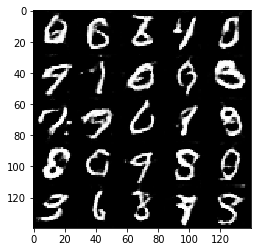

Epoch 2/2... Discriminator Loss: 0.942... Generator Loss: 0.973
Epoch 2/2... Discriminator Loss: 0.992... Generator Loss: 0.951
Epoch 2/2... Discriminator Loss: 1.441... Generator Loss: 0.459


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.55


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.232... Generator Loss: 0.974
Epoch 1/1... Discriminator Loss: 0.838... Generator Loss: 1.427
Epoch 1/1... Discriminator Loss: 1.317... Generator Loss: 1.036
Epoch 1/1... Discriminator Loss: 1.045... Generator Loss: 0.902
Epoch 1/1... Discriminator Loss: 1.197... Generator Loss: 0.733
Epoch 1/1... Discriminator Loss: 1.573... Generator Loss: 0.450
Epoch 1/1... Discriminator Loss: 1.150... Generator Loss: 1.072
Epoch 1/1... Discriminator Loss: 1.237... Generator Loss: 1.104
Epoch 1/1... Discriminator Loss: 1.163... Generator Loss: 0.744
Epoch 1/1... Discriminator Loss: 0.822... Generator Loss: 1.477


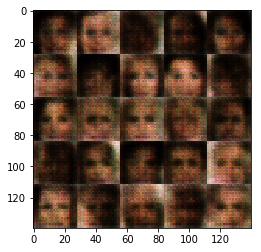

Epoch 1/1... Discriminator Loss: 1.124... Generator Loss: 1.156
Epoch 1/1... Discriminator Loss: 1.437... Generator Loss: 0.611
Epoch 1/1... Discriminator Loss: 1.457... Generator Loss: 0.651
Epoch 1/1... Discriminator Loss: 1.420... Generator Loss: 0.591
Epoch 1/1... Discriminator Loss: 1.213... Generator Loss: 0.971
Epoch 1/1... Discriminator Loss: 0.947... Generator Loss: 1.006
Epoch 1/1... Discriminator Loss: 1.202... Generator Loss: 1.694
Epoch 1/1... Discriminator Loss: 1.494... Generator Loss: 0.674
Epoch 1/1... Discriminator Loss: 1.076... Generator Loss: 1.122
Epoch 1/1... Discriminator Loss: 0.793... Generator Loss: 1.398


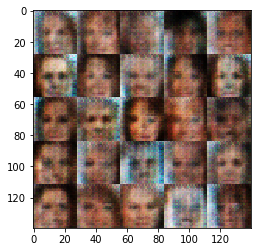

Epoch 1/1... Discriminator Loss: 1.129... Generator Loss: 0.932
Epoch 1/1... Discriminator Loss: 1.005... Generator Loss: 1.179
Epoch 1/1... Discriminator Loss: 1.402... Generator Loss: 0.836
Epoch 1/1... Discriminator Loss: 1.161... Generator Loss: 0.967
Epoch 1/1... Discriminator Loss: 1.279... Generator Loss: 0.917
Epoch 1/1... Discriminator Loss: 1.042... Generator Loss: 0.980
Epoch 1/1... Discriminator Loss: 1.224... Generator Loss: 0.813
Epoch 1/1... Discriminator Loss: 1.157... Generator Loss: 1.064
Epoch 1/1... Discriminator Loss: 1.262... Generator Loss: 1.220
Epoch 1/1... Discriminator Loss: 1.350... Generator Loss: 0.856


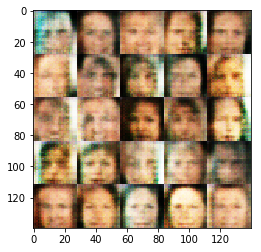

Epoch 1/1... Discriminator Loss: 1.538... Generator Loss: 0.634
Epoch 1/1... Discriminator Loss: 1.317... Generator Loss: 0.849
Epoch 1/1... Discriminator Loss: 1.204... Generator Loss: 1.026
Epoch 1/1... Discriminator Loss: 1.387... Generator Loss: 0.774
Epoch 1/1... Discriminator Loss: 1.495... Generator Loss: 0.670
Epoch 1/1... Discriminator Loss: 1.312... Generator Loss: 0.838
Epoch 1/1... Discriminator Loss: 1.268... Generator Loss: 0.818
Epoch 1/1... Discriminator Loss: 1.355... Generator Loss: 0.860
Epoch 1/1... Discriminator Loss: 1.261... Generator Loss: 0.850
Epoch 1/1... Discriminator Loss: 1.360... Generator Loss: 0.876


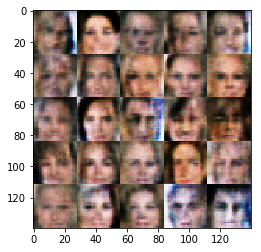

Epoch 1/1... Discriminator Loss: 1.258... Generator Loss: 0.894
Epoch 1/1... Discriminator Loss: 1.416... Generator Loss: 0.931
Epoch 1/1... Discriminator Loss: 1.304... Generator Loss: 0.839
Epoch 1/1... Discriminator Loss: 1.094... Generator Loss: 1.039
Epoch 1/1... Discriminator Loss: 1.218... Generator Loss: 0.883
Epoch 1/1... Discriminator Loss: 1.262... Generator Loss: 0.904
Epoch 1/1... Discriminator Loss: 1.304... Generator Loss: 0.908
Epoch 1/1... Discriminator Loss: 1.261... Generator Loss: 0.938
Epoch 1/1... Discriminator Loss: 1.473... Generator Loss: 0.675
Epoch 1/1... Discriminator Loss: 1.487... Generator Loss: 0.706


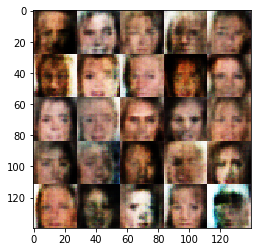

Epoch 1/1... Discriminator Loss: 1.440... Generator Loss: 0.798
Epoch 1/1... Discriminator Loss: 1.302... Generator Loss: 0.752
Epoch 1/1... Discriminator Loss: 1.498... Generator Loss: 0.748
Epoch 1/1... Discriminator Loss: 1.484... Generator Loss: 0.736
Epoch 1/1... Discriminator Loss: 1.522... Generator Loss: 0.599
Epoch 1/1... Discriminator Loss: 1.440... Generator Loss: 0.786
Epoch 1/1... Discriminator Loss: 1.401... Generator Loss: 0.796
Epoch 1/1... Discriminator Loss: 1.290... Generator Loss: 0.806
Epoch 1/1... Discriminator Loss: 1.221... Generator Loss: 0.945
Epoch 1/1... Discriminator Loss: 1.258... Generator Loss: 0.897


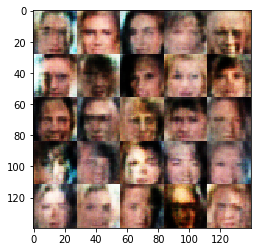

Epoch 1/1... Discriminator Loss: 1.328... Generator Loss: 0.754
Epoch 1/1... Discriminator Loss: 1.192... Generator Loss: 1.083
Epoch 1/1... Discriminator Loss: 1.357... Generator Loss: 0.690
Epoch 1/1... Discriminator Loss: 1.245... Generator Loss: 0.814
Epoch 1/1... Discriminator Loss: 1.399... Generator Loss: 0.872
Epoch 1/1... Discriminator Loss: 1.107... Generator Loss: 1.087
Epoch 1/1... Discriminator Loss: 1.365... Generator Loss: 0.781
Epoch 1/1... Discriminator Loss: 1.249... Generator Loss: 0.841
Epoch 1/1... Discriminator Loss: 1.136... Generator Loss: 0.939
Epoch 1/1... Discriminator Loss: 1.437... Generator Loss: 0.822


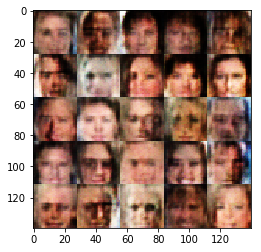

Epoch 1/1... Discriminator Loss: 1.518... Generator Loss: 0.641
Epoch 1/1... Discriminator Loss: 1.148... Generator Loss: 0.928
Epoch 1/1... Discriminator Loss: 1.295... Generator Loss: 0.769
Epoch 1/1... Discriminator Loss: 1.082... Generator Loss: 1.007
Epoch 1/1... Discriminator Loss: 1.324... Generator Loss: 0.806
Epoch 1/1... Discriminator Loss: 1.375... Generator Loss: 0.928
Epoch 1/1... Discriminator Loss: 1.575... Generator Loss: 0.558
Epoch 1/1... Discriminator Loss: 1.505... Generator Loss: 0.714
Epoch 1/1... Discriminator Loss: 1.304... Generator Loss: 0.804
Epoch 1/1... Discriminator Loss: 1.376... Generator Loss: 0.812


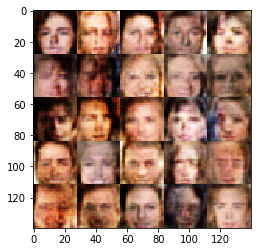

Epoch 1/1... Discriminator Loss: 1.321... Generator Loss: 0.886
Epoch 1/1... Discriminator Loss: 1.285... Generator Loss: 0.907
Epoch 1/1... Discriminator Loss: 1.464... Generator Loss: 0.725
Epoch 1/1... Discriminator Loss: 1.378... Generator Loss: 0.704
Epoch 1/1... Discriminator Loss: 1.291... Generator Loss: 0.774
Epoch 1/1... Discriminator Loss: 1.420... Generator Loss: 0.781
Epoch 1/1... Discriminator Loss: 1.203... Generator Loss: 0.950
Epoch 1/1... Discriminator Loss: 1.194... Generator Loss: 1.147
Epoch 1/1... Discriminator Loss: 1.264... Generator Loss: 0.790
Epoch 1/1... Discriminator Loss: 1.321... Generator Loss: 0.937


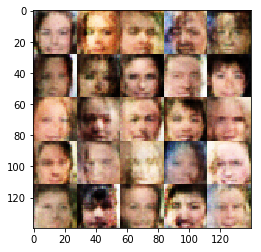

Epoch 1/1... Discriminator Loss: 1.499... Generator Loss: 0.675
Epoch 1/1... Discriminator Loss: 1.488... Generator Loss: 0.804
Epoch 1/1... Discriminator Loss: 1.463... Generator Loss: 0.680
Epoch 1/1... Discriminator Loss: 1.435... Generator Loss: 0.791
Epoch 1/1... Discriminator Loss: 1.280... Generator Loss: 0.781
Epoch 1/1... Discriminator Loss: 1.099... Generator Loss: 1.094
Epoch 1/1... Discriminator Loss: 1.451... Generator Loss: 0.783
Epoch 1/1... Discriminator Loss: 1.209... Generator Loss: 1.034
Epoch 1/1... Discriminator Loss: 1.395... Generator Loss: 0.813
Epoch 1/1... Discriminator Loss: 1.477... Generator Loss: 0.677


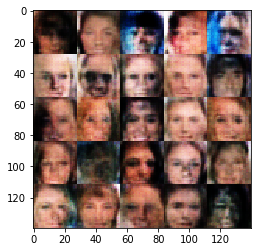

Epoch 1/1... Discriminator Loss: 1.354... Generator Loss: 0.813
Epoch 1/1... Discriminator Loss: 1.536... Generator Loss: 0.709
Epoch 1/1... Discriminator Loss: 1.242... Generator Loss: 1.074
Epoch 1/1... Discriminator Loss: 1.203... Generator Loss: 1.038
Epoch 1/1... Discriminator Loss: 1.259... Generator Loss: 0.935
Epoch 1/1... Discriminator Loss: 1.324... Generator Loss: 0.754
Epoch 1/1... Discriminator Loss: 1.374... Generator Loss: 0.705
Epoch 1/1... Discriminator Loss: 1.306... Generator Loss: 0.832
Epoch 1/1... Discriminator Loss: 1.330... Generator Loss: 0.782
Epoch 1/1... Discriminator Loss: 1.379... Generator Loss: 0.743


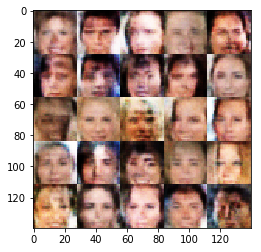

Epoch 1/1... Discriminator Loss: 1.372... Generator Loss: 0.858
Epoch 1/1... Discriminator Loss: 1.276... Generator Loss: 0.843
Epoch 1/1... Discriminator Loss: 1.409... Generator Loss: 0.743
Epoch 1/1... Discriminator Loss: 1.326... Generator Loss: 0.768
Epoch 1/1... Discriminator Loss: 1.401... Generator Loss: 0.974
Epoch 1/1... Discriminator Loss: 1.260... Generator Loss: 0.884
Epoch 1/1... Discriminator Loss: 1.406... Generator Loss: 0.831
Epoch 1/1... Discriminator Loss: 1.387... Generator Loss: 0.734
Epoch 1/1... Discriminator Loss: 1.199... Generator Loss: 0.881
Epoch 1/1... Discriminator Loss: 1.254... Generator Loss: 1.034


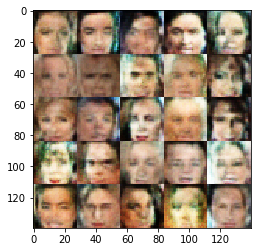

Epoch 1/1... Discriminator Loss: 1.290... Generator Loss: 0.825
Epoch 1/1... Discriminator Loss: 1.364... Generator Loss: 0.862
Epoch 1/1... Discriminator Loss: 1.345... Generator Loss: 0.778
Epoch 1/1... Discriminator Loss: 1.318... Generator Loss: 0.741
Epoch 1/1... Discriminator Loss: 1.364... Generator Loss: 0.861
Epoch 1/1... Discriminator Loss: 1.264... Generator Loss: 0.963
Epoch 1/1... Discriminator Loss: 1.243... Generator Loss: 0.903
Epoch 1/1... Discriminator Loss: 1.206... Generator Loss: 0.918
Epoch 1/1... Discriminator Loss: 1.156... Generator Loss: 0.996
Epoch 1/1... Discriminator Loss: 1.328... Generator Loss: 0.813


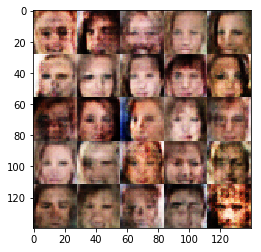

Epoch 1/1... Discriminator Loss: 1.246... Generator Loss: 0.847
Epoch 1/1... Discriminator Loss: 1.283... Generator Loss: 0.831
Epoch 1/1... Discriminator Loss: 1.267... Generator Loss: 0.927
Epoch 1/1... Discriminator Loss: 1.375... Generator Loss: 0.677
Epoch 1/1... Discriminator Loss: 1.109... Generator Loss: 1.015
Epoch 1/1... Discriminator Loss: 1.279... Generator Loss: 0.770
Epoch 1/1... Discriminator Loss: 1.277... Generator Loss: 0.937
Epoch 1/1... Discriminator Loss: 1.448... Generator Loss: 0.790
Epoch 1/1... Discriminator Loss: 1.264... Generator Loss: 0.888
Epoch 1/1... Discriminator Loss: 1.438... Generator Loss: 0.640


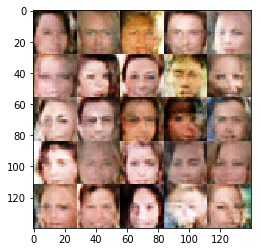

Epoch 1/1... Discriminator Loss: 1.417... Generator Loss: 0.827
Epoch 1/1... Discriminator Loss: 1.325... Generator Loss: 0.905
Epoch 1/1... Discriminator Loss: 1.236... Generator Loss: 0.915
Epoch 1/1... Discriminator Loss: 1.390... Generator Loss: 0.830
Epoch 1/1... Discriminator Loss: 1.396... Generator Loss: 0.695
Epoch 1/1... Discriminator Loss: 1.256... Generator Loss: 0.901
Epoch 1/1... Discriminator Loss: 1.266... Generator Loss: 0.961
Epoch 1/1... Discriminator Loss: 1.278... Generator Loss: 0.926
Epoch 1/1... Discriminator Loss: 1.231... Generator Loss: 0.954
Epoch 1/1... Discriminator Loss: 1.313... Generator Loss: 0.859


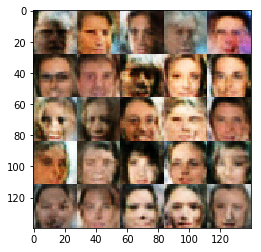

Epoch 1/1... Discriminator Loss: 1.398... Generator Loss: 0.826
Epoch 1/1... Discriminator Loss: 1.368... Generator Loss: 0.747
Epoch 1/1... Discriminator Loss: 1.323... Generator Loss: 0.860
Epoch 1/1... Discriminator Loss: 1.223... Generator Loss: 0.832
Epoch 1/1... Discriminator Loss: 1.261... Generator Loss: 0.808
Epoch 1/1... Discriminator Loss: 1.195... Generator Loss: 0.902
Epoch 1/1... Discriminator Loss: 1.288... Generator Loss: 0.805
Epoch 1/1... Discriminator Loss: 1.383... Generator Loss: 0.744


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.55


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.